<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_4_Pro_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B9_0_9713.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация текстов писателей

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, Adamax, Adadelta, Adagrad

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.preprocessing.text import Tokenizer

import numpy as np
import pandas as pd
import time # чтобы зачсечь время

import matplotlib.pyplot as plt # Для вывода графиков
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Подготовка текстов и выборки

### загружаем тексты

In [3]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Data Science и нейронные сети на Python/Занятие_4_Обработка текстов с помощью нейросетей/data/Тексты писателей')
os.listdir() # перешли в нужную папку и проверили наличие в ней нужных файлов

['(О. Генри) Обучающая_50 вместе.txt',
 '(Клиффорд_Саймак) Тестовая_2 вместе.txt',
 '(Булгаков) Обучающая_5 вместе.txt',
 '(Макс Фрай) Обучающая_5 вместе.txt',
 '(О. Генри) Тестовая_20 вместе.txt',
 '(Клиффорд_Саймак) Обучающая_5 вместе.txt',
 '(Булгаков) Тестовая_2 вместе.txt',
 '(Макс Фрай) Тестовая_2 вместе.txt',
 '(Рэй Брэдберри) Тестовая_8 вместе.txt',
 '(Стругацкие) Тестовая_2 вместе.txt',
 '(Рэй Брэдберри) Обучающая_22 вместе.txt',
 '(Стругацкие) Обучающая_5 вместе.txt',
 'modelED_RMSprop.h5',
 'modelED_Adam.h5',
 'modelED_1.h5',
 'best_modelED_RMSprop.h5',
 'best_modelED_Adam_12000_20.h5',
 'best_modelED_Adam.h5',
 'best_modelED_Adam_12000_20_2.h5',
 'best_modelED_Adam_20000_50.h5',
 'best_modelED_RMSprop_15000_20.h5',
 'best_modelED_Adam_15000_20_2.h5',
 'best_modelED_Adam_15000_20_0.9713.h5',
 'best_modelED_Adam_15000_20.h5',
 'best_modelED_RMSprop_10000_20.h5',
 'best_modelED_Adam_20000_100.h5']

In [4]:
# функция чтения файла
def readText(fileName):
  f = open(fileName, 'r') # открываем нужный файл
  text = f.read()         # читаем текст
  text = text.replace("\n", " ")  # меняем переносы строк на пробелы
  return text

# Перечислили интересующих авторов и назначили соответствующие им классы
className = ["Генри", "Стругацкие", "Булгаков", "Клиффорд", "Макс", "Брэдберри"] 
nClasses = len(className) # посчитали количество авторов

In [5]:
# Загружаем тексты писателей

trainText = []
testText = []

# считываем тексты из файлов и обрабатываем их функцией readText
for i in className:
  for j in os.listdir():
    if i in j: # если в названии файла есть имя класса (автора)

      if 'Обучающая' in  j: # если в названии файла есть слово 'Обучающая'
        trainText.append(readText(j)) # добавляем текст 
        print(j, 'добавлен в обучающую выборку')
      if 'Тестовая' in j:
        testText.append(readText(j)) # добавляем текст 
        print(j, 'добавлен в тестовую выборку')
  print()

print('Количество элементов в train:', len(trainText), '\n Количество символов в [0] элементе train: ', len(trainText[0]))

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку

Количество элементов в train: 6 
 Количество символов в [0] элементе train:  1049517


### создаем train и validaton выборки
-----
При помощи функций формирования выборки по отрезкам текста с заданным шагом

In [6]:
# разделение проиндексированного текста на короткие векторы
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна и шаг окна
  xSample = [] # пременная для векторов
  wordsLen = len(wordIndexes) # считаем колиечтсво слов
  i = 0

  while (i + xLen <= wordsLen): # пока окно внутри массива wordIndexes
    xSample.append(wordIndexes[i:i+xLen]) # Отрезаем векторы длины xLen
    i += step # смещение на шаг вперед
  
  return xSample

In [7]:
# создаем train и val выборки
def createSetMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна и шаг окна
  nClases = len(wordIndexes) # количество влассов в выборке
  classesXSamples = [] # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes: # для каждого текста каждого класса
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 
  
  xSamples = []
  ySamples = []

  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

In [8]:
# Представляем тестовую выборку в удобных для распознавания размерах
def createTestMultiClasses(wordIndexes, xLen, step): #функция принимает последовательность индексов, размер окна, шаг окна

  #Для каждого из 6 классов
  #Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) #Задаем количество классов
  xTest6Classes01 = []               #Здесь будет список из всех классов, каждый размером "кол-во окон в тексте * 20000 (при maxWordsCount=20000)"
  xTest6Classes = []                 #Здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:                       #Для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) #Тестовая выборка размером "кол-во окон*длину окна"(например, 420*1000)
    xTest6Classes.append(sample)              # Добавляем в список
    xTest6Classes01.append(tokenizerED.sequences_to_matrix(sample)) #Трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest6Classes01 = np.array(xTest6Classes01)                     #И добавляется к нашему списку, 
  xTest6Classes = np.array(xTest6Classes)                     #И добавляется к нашему списку, 
  
  return xTest6Classes01, xTest6Classes  #функция вернёт тестовые данные: TestBag 6 классов на n*20000 и xTestEm 6 по n*1000

# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  totalSumRec = 0 # Сумма всех правильных ответов
  
  #Проходим по всем классам
  for i in range(nClasses):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) #Определяем, какой класс в итоге за какой был распознан
    
    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()
  
  return totalSumRec/sumCount

## **bag of words**

### подготовка данных

In [ ]:
from tensorflow.keras import utils # Для работы с категориальными данными
import numpy as np

In [ ]:
# базовые параметры
xLen = 10000 # длина отрезка анализируемого текста
step = 100 # длина обучающих векторов, на которые разбили текст

In [ ]:
cur_time = time.time() # Засекаем текущее время

#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
"""
получили обучающий/тестовый набор, достаточный для запуска Embedding,
но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
"""

print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17100, 10000)
(17100, 6)
(6146, 10000)
(6146, 6)
Время обработки: 19.1c


In [ ]:
print(xTrain[0])

[ 4725     7  2449 ...    59 12357   913]


In [ ]:
cur_time = time.time() # Засекаем текущее время

### bag of words ###
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100])   # Фрагмент набора слов в виде Bag of Words
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17100, 20000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
Время обработки: 64.29c


### создаем нейросеть

In [ ]:
k_Dropout = 0.25
k_Dense = 200
k_epochs = 10
batch_size = 128

Epoch 1/10
134/134 [==============================] - 2s 12ms/step - loss: 0.3179 - accuracy: 0.9840 - val_loss: 0.6341 - val_accuracy: 0.9740
Epoch 2/10
134/134 [==============================] - 1s 10ms/step - loss: 0.0765 - accuracy: 0.9754 - val_loss: 0.2871 - val_accuracy: 0.9748
Epoch 3/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0245 - accuracy: 0.9968 - val_loss: 0.1811 - val_accuracy: 0.9810
Epoch 4/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.1220 - val_accuracy: 0.9823
Epoch 5/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0948 - val_accuracy: 0.9826
Epoch 6/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0767 - val_accuracy: 0.9816
Epoch 7/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0680 - val_accuracy: 0.9841
Epoc

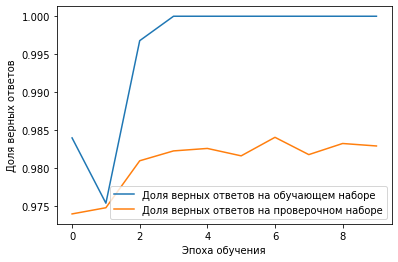

In [ ]:
model01 = Sequential()
model01.add(Dense(k_Dense, input_dim=maxWordsCount, activation='relu')) # послносвязный слой
model01.add(Dropout(k_Dropout)) # регуляризация
model01.add(BatchNormalization()) # пакетная нормализация
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# обучение на выборке от bag of words - xTrain01
history = model01.fit(xTrain01, yTrain,
                      epochs = k_epochs,
                      batch_size = batch_size,
                      validation_data = (xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### распознавание на проверочной выборке

In [ ]:
xTest6Classes01, x2 = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки

In [ ]:
l = np.array(xTest6Classes01)
np.save('xTestPredictBoW', l)
np.save('xTestPredictEmbedding', x2)

In [ ]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model01, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

Класс: Генри      100% сеть отнесла к классу Генри     Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 98% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   100% сеть отнесла к классу Булгаков  Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак    100% сеть отнесла к классу Саймак   Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай      95% сеть отнесла к классу Фрай      Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  100% сеть отнесла к классу Брэдберри Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 98%



### обрабатываем тексты

In [ ]:
cur_time = time.time() # засекаем время

maxWordsCount = 5000 # Определили максимальное количество слов, учитываемых при обучении

tokenizer = Tokenizer(num_words = maxWordsCount, # обрабатываем текст, оставляя только те слова, на которых учимся
                      filters='"!#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', # избавляемся от этих символов
                      lower=True,           # переводим в нижний регистр
                      split=' ',            # разделяем слова пробелом
                      oov_token='unknown',  # ???
                      char_level=False)     # оставляем слова из одной буквы

tokenizer.fit_on_texts(trainText) # сзодаем словарь частотности для наших текстов
items = list(tokenizer.word_index.items()) # заносим индексы слов в словарь

print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='') # смотрим время

Время обработки: 2.55c


In [ ]:
print('Пять самых ЧАСТО встречающихся слов: ', items[:5])
print('Пять самых РЕДКО встречающихся слов: ', items[-5:])
print('Размер словаря', len(items))
print()
print("Индекс слова: ", tokenizer.word_index[input('Наберите слово: ')])

Пять самых ЧАСТО встречающихся слов:  [('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5)]
Пять самых РЕДКО встречающихся слов:  [('потерян', 133066), ('расплывающиеся', 133067), ('миллионе', 133068), ('зияющая', 133069), ('ничтонавстречу', 133070)]
Размер словаря 133070

Наберите слово: деревня
Индекс слова:  12834


### преобразуем текст в последовательность элементов

In [ ]:
trainWordIndexes = tokenizer.texts_to_sequences(trainText)  # оцифровал обучающие тексты
testWordIndexes = tokenizer.texts_to_sequences(testText)    # оцифровал тестовые тексты

print('Фрагмент обуающего текста: ', trainText[1][:51]) ### надо бы убрать цифры их массивов
print('Он же в виде последовательности индексов: ', trainWordIndexes[1][:51])

Фрагмент обуающего текста:  Парень из преисподней     1     Ну и деревня! Сроду
Он же в виде последовательности индексов:  [473, 22, 1, 1508, 47, 2, 1, 1, 5, 415, 1, 4, 251, 2, 4, 249, 55, 6, 240, 1, 2630, 182, 1, 1, 99, 3527, 1, 7, 1, 11, 1, 1, 10, 67, 301, 116, 34, 4, 1, 1, 196, 12, 1, 1, 1, 1, 1, 1, 1, 1035, 175]


In [ ]:
print("Статистика по обучающим текстам:")

symbolsTrainText = 0 # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0 # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(nClasses): # Проходим по всем классам
  print(className[i], " "*(10-len(className[i])), len(trainText[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(trainText[i]) # Считаем символы
  wordsTrainText += len(trainWordIndexes[i]) # Считаем слова 

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0 # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0 # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(nClasses): #Проходим по всем классам
  print(className[i], ' '*(12-len(className[i])), len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(testText[i]) #Считаем символы
  wordsTestText += len(testWordIndexes[i]) #Считаем слова 
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
Генри       1049517 символов,  160607 слов
Стругацкие  2042469 символов,  313012 слов
Булгаков    1765648 символов,  261465 слов
Клиффорд    1609507 символов,  251502 слов
Макс        3700010 символов,  568533 слов
Брэдберри   1386454 символов,  214454 слов
----
В сумме  11553605  символов,  1769573  слов 


Статистика по тестовым текстам:
Генри         349662 символов,  53238 слов
Стругацкие    704846 символов,  108621 слов
Булгаков      875042 символов,  132730 слов
Клиффорд      318811 символов,  50360 слов
Макс          1278191 символов,  196731 слов
Брэдберри     868673 символов,  132524 слов
----
В сумме  4395225  символов,  674204  слов


## **Embedding + Dense**
---
3. Запустите нейронку c Embbedding при maxWordsCount = 50000, поменяйте размер Embedding
пространства
* 10
* 50
* 200


In [9]:
maxWordsCount = 50000 # Определили максимальное количество слов, учитываемых при обучении

tokenizerED = Tokenizer(num_words = maxWordsCount, # обрабатываем текст, оставляя только те слова, на которых учимся
                        filters='0123456789"!#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', # избавляемся от этих символов
                        lower=True,           # переводим в нижний регистр
                        split=' ',            # разделяем слова пробелом
                        oov_token='unknown',  # ???
                        char_level=False)     # оставляем слова из одной буквы

tokenizerED.fit_on_texts(trainText) # сзодаем словарь частотности для наших текстов
itemsED = list(tokenizerED.word_index.items()) # заносим индексы слов в словарь

# преобразую текст в последовательность элементов
trainWordIndexesED = tokenizerED.texts_to_sequences(trainText)  # оцифровал обучающие тексты
testWordIndexesED = tokenizerED.texts_to_sequences(testText)    # оцифровал тестовые тексты
print('Фрагмент обуающего текста: ', trainText[1][:51]) ### надо бы убрать цифры их массивов
print('Он же в виде последовательности индексов: ', trainWordIndexesED[1][:51])

symbolsTrainTexED = 0 # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainTextED = 0 # Объявляем переменную для подсчета слов в обучающих текстах


Фрагмент обуающего текста:  Парень из преисподней     1     Ну и деревня! Сроду
Он же в виде последовательности индексов:  [473, 22, 29082, 47, 2, 12788, 7770, 5, 415, 27496, 4, 251, 2, 4, 249, 55, 6, 240, 9436, 2625, 182, 5796, 24082, 99, 3518, 19746, 7, 1, 11, 32399, 1, 10, 67, 301, 116, 34, 4, 34312, 19747, 196, 12, 11214, 42440, 19748, 42441, 8701, 1, 11610, 1034, 175, 7336]


In [ ]:
cur_time = time.time() # засекаем время

batch_size = 64
k_Dense = 6
k_Dropout = 0.4
epochs = 100
N_lr = 0.00005

data = []

N_xLen = [15000] # хорошо при 20000
N_step = [20]
N_Emb = [50] # Кол-во нейронов в скрытом слое

for xLen in N_xLen:
  for step in N_step:
    xTrainED, yTrainED = createSetMultiClasses(trainWordIndexesED, xLen, step) #извлекаем обучающую выборку
    xTestED, yTestED = createSetMultiClasses(testWordIndexesED, xLen, step)    #извлекаем тестовую выборку

    for k_Embbeding in N_Emb:
      modelED = Sequential()

      modelED.add(Embedding(maxWordsCount, k_Embbeding, input_length=xLen))
      modelED.add(SpatialDropout1D(k_Dropout))
      #modelED.add(Dropout(k_Dropout))
      modelED.add(Flatten())

      #modelED.add(Dense(k_Embbeding, activation='relu'))
      #modelED.add(Dropout(k_Dropout))

      modelED.add(Dense(k_Dense, activation='softmax'))

      modelED.compile(optimizer=Adam(N_lr),
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

      
      # остановки обучения по условию 
      early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                                    patience = 4, verbose = 1,
                                    restore_best_weights = True)
      Checkpoint = ModelCheckpoint('best_modelED_Adam_15000_20.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


      print('Emb = ', k_Embbeding, 'xLen = ', xLen, 'step = ', step)

      #Обучаем на xTrain
      historyED = modelED.fit(xTrainED, yTrainED, 
                              epochs=epochs, verbose=1,
                              callbacks = [early_stopping, Checkpoint],
                              validation_data = (xTestED, yTestED))


      plt.plot(historyED.history['accuracy'], 
              label='Доля верных ответов на обучающем наборе')
      plt.plot(historyED.history['val_accuracy'], 
              label='Доля верных ответов на проверочном наборе')
      plt.xlabel('Эпоха обучения')
      plt.ylabel('Доля верных ответов')
      plt.legend()
      plt.grid()
      plt.show()

      data = data + [[maxWordsCount, batch_size, k_Dense, k_Dropout, k_Embbeding,  'relu', 'softmax', 'Adam', xLen, step, max(historyED.history['val_accuracy'])]]

      #Проверяем результаты работы Ebedding сети
      _, xTest6Classes = createTestMultiClasses(testWordIndexesED, xLen, step) #Преобразование тестовой выборки для predict
      predict = recognizeMultiClass(modelED, xTest6Classes, "Embedding + Dense")


print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='') # смотрим время

results = pd.DataFrame(data, columns = ['maxWordsCount', 'batch_size', 'Dense', 'Dropout', 'Embbeding', 'Ativation', 'Activation', 'Optimizer', 'xLen', 'step', 'predict'])
results


Emb =  50 xLen =  15000 step =  20
Epoch 1/100
2619/2620 [============================>.] - ETA: 0s - loss: 0.2595 - accuracy: 0.9258
Epoch 00001: val_accuracy improved from -inf to 0.88766, saving model to best_modelED_Adam_15000_20.h5
2620/2620 [==============================] - 195s 74ms/step - loss: 0.2595 - accuracy: 0.9258 - val_loss: 0.4800 - val_accuracy: 0.8877
Epoch 2/100
1993/2620 [=====================>........] - ETA: 42s - loss: 0.0019 - accuracy: 1.0000

In [10]:
from tensorflow.keras.models import load_model

batch_size = 64
k_Dense = 6
k_Dropout = 0.4
epochs = 100
N_lr = 0.00005
xLen = 15000 # хорошо при 20000 но не хватает памяти ((
step = 20
k_Embbeding = 50 # Кол-во нейронов в скрытом слое

modelED = Sequential()
modelED = load_model('best_modelED_Adam_15000_20_0.9713.h5')

#Проверяем результаты работы Ebedding сети
_, xTest6Classes = createTestMultiClasses(testWordIndexesED, xLen, step) #Преобразование тестовой выборки для predict
predict = recognizeMultiClass(modelED, xTest6Classes, "Embedding + Dense")

НЕЙРОНКА:  Embedding + Dense

Класс: Генри      100% сеть отнесла к классу Генри     Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 99% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   88% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Клиффорд   92% сеть отнесла к классу Клиффорд   Это ПРАВИЛЬНЫЙ ответ!
Класс: Макс       99% сеть отнесла к классу Макс       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  100% сеть отнесла к классу Брэдберри Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 97%



In [ ]:
# k_Dropout = 0.4 # было 0.4 + N_lr = 0.00005, Dense = k_Embbeding
results = pd.DataFrame(data, columns = ['maxWordsCount', 'batch_size', 'Dense', 'Dropout', 'Embbeding', 'Activation', 'Activation', 'Optimizer', 'xLen', 'step', 'predict'])
results 

,maxWordsCount,batch_size,Dense,Dropout,Embbeding,Activation,Activation,Optimizer,xLen,step,predict
0,50000,64,6,0.4,50,relu,softmax,Adam,5000,20,0.886849
1,50000,64,6,0.4,50,relu,softmax,Adam,10000,20,0.904161


In [ ]:
results = pd.DataFrame(data, columns = ['maxWordsCount', 'batch_size', 'Dense', 'Dropout', 'Embbeding', 'Activation', 'Activation', 'Optimizer', 'xLen', 'step', 'predict'])
results   # k_Dropout = 0.7

,maxWordsCount,batch_size,Dense,Dropout,Embbeding,Activation,Activation,Optimizer,xLen,step,predict
0,50000,64,6,0.7,50,relu,softmax,Adam,10000,20,0.946394


In [ ]:
results = pd.DataFrame(data, columns = ['maxWordsCount', 'batch_size', 'Dense', 'Dropout', 'Embbeding', 'Activation', 'Activation', 'Optimizer', 'xLen', 'step', 'predict'])
results
# N_lr = 0.00005

,maxWordsCount,batch_size,Dense,Dropout,Embbeding,Activation,Activation,Optimizer,xLen,step,predict
0,50000,64,6,0.2,50,relu,softmax,Adam,10000,20,0.956007


,maxWordsCount,batch_size,Dense,Dropout,Embbeding,Activation,Activation,Optimizer,xLen,step,predict
0,50000,64,6,0.2,50,relu,softmax,Adam,10000,20,0.956007


In [ ]:
results = pd.DataFrame(data, columns = ['maxWordsCount', 'batch_size', 'Dense', 'Dropout', 'Embbeding', 'Activation', 'Activation', 'Optimizer', 'xLen', 'step', 'predict'])
results

,maxWordsCount,batch_size,Dense,Dropout,Embbeding,Activation,Activation,Optimizer,xLen,step,predict
0,50000,64,6,0.2,50,relu,softmax,Adam,15000,20,0.926885


In [ ]:
results = pd.DataFrame(data, columns = ['maxWordsCount', 'batch_size', 'Dense', 'Dropout', 'Embbeding', 'Activation', 'Activation', 'Optimizer', 'xLen', 'step', 'predict'])
results

,maxWordsCount,batch_size,Dense,Dropout,Embbeding,Activation,Activation,Optimizer,xLen,step,predict
0,50000,64,6,0.2,50,relu,softmax,Adam,10000,20,0.957018


In [ ]:
results = pd.DataFrame(data, columns = ['maxWordsCount', 'batch_size', 'Dense', 'Dropout', 'Embbeding', 'Activation', 'Activation', 'Optimizer', 'xLen', 'step', 'predict'])
results

,maxWordsCount,batch_size,Dense,Dropout,Embbeding,Activation,Activation,Optimizer,xLen,step,predict
0,50000,64,6,0.6,50,relu,softmax,Adam,10000,20,0.926842


In [ ]:
results = pd.DataFrame(data, columns = ['maxWordsCount', 'batch_size', 'Dense', 'Dropout', 'Embbeding', 'Activation', 'Activation', 'Optimizer', 'xLen', 'step', 'predict'])
results
#Оставил только один Dense слой с 6ю нейронами + SpatialDropout1D 0.4

,maxWordsCount,batch_size,Dense,Dropout,Embbeding,Activation,Activation,Optimizer,xLen,step,predict
0,50000,128,6,0.4,50,relu,softmax,Adam,10000,20,0.933099


In [ ]:
results = pd.DataFrame(data, columns = ['maxWordsCount', 'batch_size', 'Dense', 'Dropout', 'Embbeding', 'relu', 'softmax', 'RMSprop', 'xLen', 'step', 'predict'])
results
#Оставил только один Dense слой с 6ю нейронами

,maxWordsCount,batch_size,Dense,Dropout,Embbeding,relu,softmax,RMSprop,xLen,step,predict
0,5000,128,200,0.2,50,relu,softmax,RMSprop,20000,50,0.970386


In [ ]:
results = pd.DataFrame(data, columns = ['maxWordsCount', 'batch_size', 'Dense', 'Dropout', 'Embbeding', 'relu', 'softmax', 'RMSprop', 'xLen', 'step', 'predict'])
results

,maxWordsCount,batch_size,Dense,Dropout,Embbeding,relu,softmax,RMSprop,xLen,step,predict
0,5000,128,200,0.2,50,relu,softmax,RMSprop,5000,50,0.930569
1,5000,128,200,0.2,50,relu,softmax,RMSprop,10000,50,0.941756


In [ ]:
results
# Adam + Dropout = 0.2

,maxWordsCount,batch_size,Dense,Dropout,Embbeding,relu,xLen,step,predict
0,50000,128,200,0.2,10,relu,1000,20,0.765927
1,50000,128,200,0.2,50,relu,1000,20,0.754096
2,50000,128,200,0.2,100,relu,1000,20,0.825171
3,50000,128,200,0.2,200,relu,1000,20,0.772966


In [ ]:
results
# Adam + Dropout = 0.2

Длина отрезка текста, по которой анализируем, в словах:  200 
 Шаг разбиения исходного текста на обучающие векторы:  20


,maxWordsCount,batch_size,Dense,Dropout,Embbeding,relu,xLen,step,predict
0,50000,128,200,0.2,10,relu,200,20,0.681387
1,50000,128,200,0.2,50,relu,200,20,0.694174
2,50000,128,200,0.2,100,relu,200,20,0.684063
3,50000,128,200,0.2,200,relu,200,20,0.682101


In [ ]:
print(modelED.summary())

NameError: ignored

In [ ]:
modelED.save_weights('modelED_Adam.h5')
modelED.load_weights('modelED_Adam.h5')